In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def modern_posit(image_pts, world_pts, focal_length, center):
    """Finds the optimal matrix of rotation and transformation, based on 2D and 3D coordinates

    Args:
        image_pts ([type]): [description]
        world_pts ([type]): [description]
        focal_length ([type]): [description]
        center ([type]): [description]

    Returns:
        rot (np.array), trans (np.array), count(int): [description]
    """
    nb_points = np.shape(image_pts)[0]

    # centered & scaled pixel coordinates
    centered_image = np.divide(np.subtract(image_pts, center), focal_length)
    ui = centered_image[:, 0]
    vi = centered_image[:, 1]

    # homogeneous world coordinates
    homogeneous_world_pts = np.append(world_pts, np.ones((nb_points, 1)), 1)

    # pseudo inverse
    object_mat = np.linalg.pinv(homogeneous_world_pts)
    # print(object_mat)

    converged = 0
    count = 0
    t_x = 0.0
    t_y = 0.0
    t_z = 0.0
    r1 = 0.0
    r2 = 0.0
    r3 = 0.0
    while converged == 0:
        # POS part of the algorithm
        # rotation vectors
        r1_t = np.matmul(object_mat, ui)
        r2_t = np.matmul(object_mat, vi)
        # 1/t_z1 is norm of r1_t
        t_z1 = 1 / np.linalg.norm(r1_t[0:3])
        # 1/tz_2 is norm of r2_t
        t_z2 = 1 / np.linalg.norm(r2_t[0:3])

        # geometric average
        t_z = np.sqrt(t_z1 * t_z2)

        r1_n = np.multiply(r1_t, t_z)
        r2_n = np.multiply(r2_t, t_z)
        r1 = r1_n[0:3]
        r2 = r2_n[0:3]
        r3 = np.cross(r1, r2)
        r3_t = np.append(r3, t_z)
        t_x = r1_n[3]
        t_y = r2_n[3]

        # Now update the z/T z or epsilon
        # then ui, vi
        epsilon_i = np.matmul(homogeneous_world_pts, np.divide(r3_t, t_z))
        old_ui = ui
        old_vi = vi
        ui = np.multiply(epsilon_i, centered_image[:, 0])
        vi = np.multiply(epsilon_i, centered_image[:, 1])

        # check for convergence
        delta_ui = ui - old_ui
        delta_vi = vi - old_vi
        delta = np.square(focal_length) * (
            np.square(np.linalg.norm(delta_ui)) + np.square(np.linalg.norm(delta_vi))
        )

        converged = 1 if count > 0 and delta < 1 else 0
        count = count + 1
        if count > 1000:
            break

    trans = np.array([t_x, t_y, t_z], np.float64)
    rot = np.array([r1, r2, r3], np.float64)

    return rot, trans, count


def check_rotation_matrix(points_2d, points_3d, intrin, rot, trans):
    rottrans = np.append(rot, trans.reshape(3, 1), axis=1)  # объединяем их в одну (3,4)
    print(rottrans)
    full_matrix = np.matmul(intrin, rottrans)
    projected_points_2d = np.matmul(
        full_matrix,
        np.transpose(np.append(points_3d, np.ones((points_3d.shape[0], 1)), axis=1)),
    )
    projected_points_2d_t = np.transpose(projected_points_2d)  # транспонируем (6,3)
    # Происходит магия, на выходе (6,3)
    projected_points_2d_homogen = projected_points_2d_t / projected_points_2d[
        2
    ].reshape(points_3d.shape[0], 1)
    print(
        f"Error of rotation: {np.linalg.norm(points_2d - projected_points_2d_homogen[:,0:2])}"
    )
    plt.scatter(points_2d[:, 0], points_2d[:, 1], color="g", s=500, alpha=0.5)
    plt.scatter(
        projected_points_2d_homogen[:, 0],
        projected_points_2d_homogen[:, 1],
        color="blue",
        marker="x",
    )
    return plt.show()


points_2d = np.array(
    [
        [180.0, 453.0],
        [980.0, 326.0],
        #    [505., 354.],
        #    [649., 238.],
        #    [692., 351.],
        [547.0, 411.0],
    ]
)

points_3d = np.array(
    [
        [30.46, 26.75, 0.0],
        [54.31, 23.5, 0.0],
        #    [40.55, 22.81,  0.  ],
        #    [42.05, 34.3 ,  0.  ],
        #    [45.49, 24.78,  0.  ],
        [42.98, 15.25, 0.0],
    ]
)


# Posit

[[  0.64289272  -0.66970755   0.         -21.55280388]
 [  0.77336407  -0.7498294    0.         -27.22073712]
 [  0.           0.           0.0358679    0.91921811]]
Error of rotation: 2.973823638970582e-11


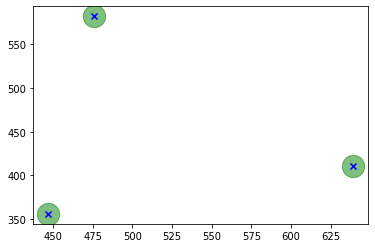

In [45]:
# Posit
intrin = np.array(
    [
        [1920, 0, 640],
        [0, 1920, 360],
        [0, 0, 1],
    ],
    dtype=np.float32,
)
rot, trans, _ = modern_posit(points_2d, points_3d, 1920, [640, 360])

check_rotation_matrix(points_2d, points_3d, intrin, rot, trans)


# pNp

In [211]:
cv2.solvePnP(
    points_3d,
    points_2d,
    intrin,
    np.zeros((4, 1)),
    flags=cv2.SOLVEPNP_ITERATIVE,
    useExtrinsicGuess=True,
)


error: OpenCV(4.5.2) /private/var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/pip-req-build-0kq15xu_/opencv/modules/calib3d/src/solvepnp.cpp:835: error: (-215:Assertion failed) !_rvec.empty() && !_tvec.empty() in function 'solvePnPGeneric'


In [174]:
flags = [
    cv2.SOLVEPNP_ITERATIVE,  # 0
    cv2.SOLVEPNP_P3P,  # 2
    cv2.SOLVEPNP_AP3P,  # 5
    cv2.SOLVEPNP_EPNP,  # 1
    cv2.SOLVEPNP_DLS,  # 3
    cv2.SOLVEPNP_UPNP,  # 4
    cv2.SOLVEPNP_IPPE,  # 6
    cv2.SOLVEPNP_IPPE_SQUARE,  # 7
    cv2.SOLVEPNP_SQPNP,  # 8
]


0 works
[[-9.42635133e-01 -2.83023088e-01  1.77022424e-01  4.79004975e+01]
 [ 1.52357957e-01  1.07085882e-01  9.82506828e-01 -9.46007502e+00]
 [-2.97028718e-01  9.53116229e-01 -5.78220947e-02 -6.39396014e+01]]
Error of rotation: 48.22863982565711


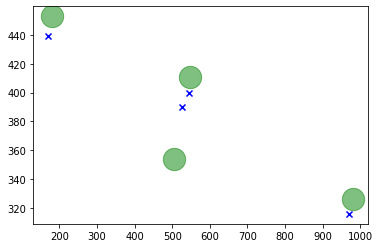

2 works
[[ 9.95748626e-01  1.79252560e-02 -9.03513068e-02 -4.46318598e+01]
 [-8.59952941e-02  5.32393884e-01 -8.42117309e-01 -8.82770101e+00]
 [ 3.30073148e-02  8.46306940e-01  5.31671966e-01  3.40471120e+01]]
Error of rotation: 227.95806390271466


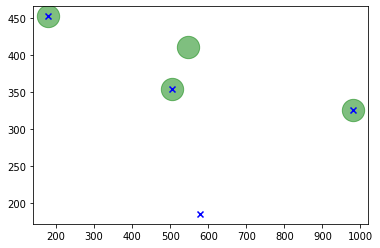

5 works
[[ 9.95748626e-01  1.79252555e-02 -9.03513072e-02 -4.46318598e+01]
 [-8.59952942e-02  5.32393883e-01 -8.42117309e-01 -8.82770099e+00]
 [ 3.30073154e-02  8.46306941e-01  5.31671966e-01  3.40471119e+01]]
Error of rotation: 227.95806366450728


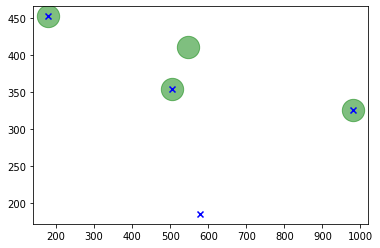

1 works
[[ 4.20888676e-01 -5.41562760e-01 -7.27710450e-01  1.41925862e+34]
 [ 2.12507287e-01  8.38769635e-01 -5.01304451e-01 -2.64530134e+34]
 [ 8.81869251e-01  5.63495928e-02  4.68114674e-01  2.66989246e+34]]
Error of rotation: 4484.92296416111


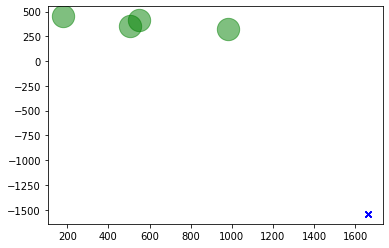

3 works
[[ 4.20888676e-01 -5.41562760e-01 -7.27710450e-01  1.41925862e+34]
 [ 2.12507287e-01  8.38769635e-01 -5.01304451e-01 -2.64530134e+34]
 [ 8.81869251e-01  5.63495928e-02  4.68114674e-01  2.66989246e+34]]
Error of rotation: 4484.92296416111


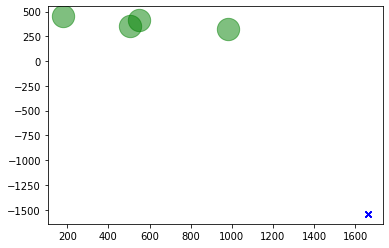

4 works
[[ 4.20888676e-01 -5.41562760e-01 -7.27710450e-01  1.41925862e+34]
 [ 2.12507287e-01  8.38769635e-01 -5.01304451e-01 -2.64530134e+34]
 [ 8.81869251e-01  5.63495928e-02  4.68114674e-01  2.66989246e+34]]
Error of rotation: 4484.92296416111


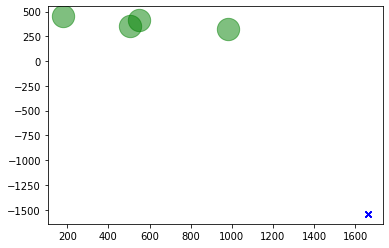

6 works
[[-4.98816186e-01 -7.55895332e-01  4.24033795e-01  3.77827010e+01]
 [ 2.49043953e-01  3.43607099e-01  9.05489520e-01 -1.82736244e+01]
 [-8.30156324e-01  5.57275881e-01  1.68543790e-02 -4.49815360e+00]]
Error of rotation: 340.3520472132044


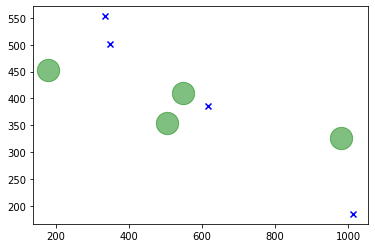

7 works
[[-9.71790970e-01 -9.95635939e-02 -2.13797573e-01  4.56974800e+01]
 [ 2.16966575e-01 -2.20428438e-02 -9.75930130e-01 -9.36593591e+00]
 [ 9.24544046e-02 -9.94787014e-01  4.30230085e-02 -3.37692894e+01]]
Error of rotation: 72.84207895043778


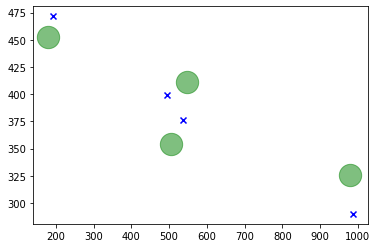

8 works
[[ 9.85726536e-01  5.48611528e-02 -1.59164853e-01 -4.52845489e+01]
 [-1.56578405e-01 -4.86233716e-02 -9.86467927e-01  8.38716436e+00]
 [-6.18578995e-02  9.97309391e-01 -3.93392759e-02  3.29916679e+01]]
Error of rotation: 47.88659578571005


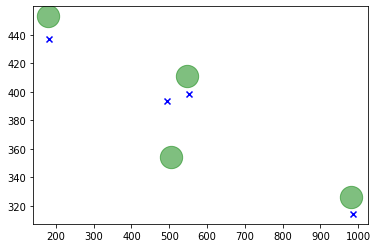

In [175]:
for flag in flags:
    try:
        intrin = np.array(
            [
                [1920, 0, 640],
                [0, 1920, 360],
                [0, 0, 1],
            ],
            dtype=np.float32,
        )
        dist_coeffs = np.zeros((4, 1), dtype=np.float32)
        _, rotation_vector, trans = cv2.solvePnP(
            points_3d, points_2d, intrin, distCoeffs=dist_coeffs, flags=flag
        )
        rot, _ = cv2.Rodrigues(rotation_vector)
        print(f"{flag} works")
        check_rotation_matrix(points_2d, points_3d, intrin, rot, trans)
    except:
        print(f"!!!!!! {flag} has errors")


In [ ]:
# with errors:
# cv2.SOLVEPNP_P3P, # 2
# cv2.SOLVEPNP_AP3P, # 5
# cv2.SOLVEPNP_IPPE_SQUARE, # 7


# Ransac

In [47]:
_, rotation_vector, trans, _ = cv2.solvePnPRansac(
    points_3d, points_2d, intrin, np.zeros((4, 1), dtype=np.float32)
)
rot, _ = cv2.Rodrigues(rotation_vector)
print(f"{flag} works")
check_rotation_matrix(points_2d, points_3d, intrin, rot, trans)


error: OpenCV(4.5.2) /private/var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/pip-req-build-0kq15xu_/opencv/modules/calib3d/src/solvepnp.cpp:241: error: (-215:Assertion failed) npoints >= 4 && npoints == std::max(ipoints.checkVector(2, CV_32F), ipoints.checkVector(2, CV_64F)) in function 'solvePnPRansac'


In [49]:
_, rotation_vector, trans, _ = cv2.solvePnPGeneric(
    points_3d, points_2d, intrin, np.zeros((4, 1), dtype=np.float32), flags=cv2.SOLVEPNP_IPPE
)
rot, _ = cv2.Rodrigues(rotation_vector)
print(f"{flag} works")
check_rotation_matrix(points_2d, points_3d, intrin, rot, trans)


error: OpenCV(4.5.2) /private/var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/pip-req-build-0kq15xu_/opencv/modules/calib3d/src/solvepnp.cpp:826: error: (-215:Assertion failed) ( (npoints >= 4) || (npoints == 3 && flags == SOLVEPNP_ITERATIVE && useExtrinsicGuess) || (npoints >= 3 && flags == SOLVEPNP_SQPNP) ) && npoints == std::max(ipoints.checkVector(2, CV_32F), ipoints.checkVector(2, CV_64F)) in function 'solvePnPGeneric'


- Numpy array slices won't work as input because solvePnP requires contiguous arrays (enforced by the assertion using cv::Mat::checkVector() around line 55 of modules/calib3d/src/solvepnp.cpp version 2.4.9)
- The P3P algorithm requires image points to be in an array of shape (N,1,2) due to its calling of cv::undistortPoints (around line 75 of modules/calib3d/src/solvepnp.cpp version 2.4.9) which requires 2-channel information.
- Thus, given some data D = np.array(...) where D.shape = (N,M), in order to use a subset of it as, e.g., imagePoints, one must effectively copy it into a new array: imagePoints = np.ascontiguousarray(D[:,:2]).reshape((N,1,2))


In [215]:
points_2d


array([[180., 453.],
       [980., 326.],
       [547., 411.]])

# solvep3p

In [22]:
points_3d_1 = np.array([[59.58, 25.15, 0.0], [61.31, 26.79, 0.0], [58.15, 23.64, 0.0]])
points_2d_1 = np.array([[447.0, 356.0], [476.0, 582.0], [639.0, 411.0]])

points_3d_2 = np.array([[59.58, 25.15, 0.0], [61.31, 26.79, 0.0], [57.79, 27.27, 0.0]])
points_2d_2 = np.array([[447.0, 356.0], [476.0, 582.0], [639.0, 411.0]])

points_3d_3 = np.array([[109.43, 24.5, 0.0], [109.8, 16.94, 0.0], [109.35, 25.82, 0.0]])
points_2d_3 = np.array([[804.0, 424.0], [481.0, 330.0], [949.0, 337.0]])

points_3d_4 = np.array([[109.43, 24.5, 0.0], [109.72, 19.88, 0.0], [109.35, 25.82, 0.0]])
points_2d_4 = np.array([[804.0, 424.0], [481.0, 330.0], [949.0, 337.0]])

tst_list = [(points_3d_1, points_2d_1),(points_3d_2, points_2d_2),(points_3d_3, points_2d_3),(points_3d_4, points_2d_4),]

In [40]:
def p3p_posit_simple(points_2d, points_3d, cameraMatrix, flag, rot, trans):
    distCoeffs = np.zeros((4, 1), dtype=np.float32)

    rez_list = cv2.solveP3P(points_3d, points_2d, cameraMatrix, distCoeffs, flag)
    if rez_list[0] != 0:
        rotation_vector, trans = rez_list[1][0], rez_list[2][0]
        rot, _ = cv2.Rodrigues(rotation_vector)
        return rot, trans
    else:
        print('wrong')
    # return rot, trans


In [50]:
# rot = np.random.randn(3, 3)
# trans = np.random.randn(3, 1)
cameraMatrix = np.array(
        [[1920, 0, 640], [0, 1920, 360], [0, 0, 1]], dtype=np.float32
    )

for points_3d,points_2d in tst_list:
    rot, trans = p3p_posit_simple(points_2d, points_3d,cameraMatrix, cv2.SOLVEPNP_P3P, rot, trans)
    check_rotation_matrix(points_2d, points_3d, intrin, rot, trans)

    

wrong


TypeError: cannot unpack non-iterable NoneType object

1920.0 2 (0, [], [])
960.0 2 (0, [], [])
480.0 2 (0, [], [])
240.0 2 (0, [], [])
3840.0 2 (0, [], [])
7680.0 2 (0, [], [])
15360.0 2 (0, [], [])
30720.0 2 (0, [], [])
61440.0 2 (0, [], [])
122880.0 2 (0, [], [])
245760.0 2 (1, [array([[-0.96869831],
       [ 1.56916132],
       [-1.62802228]])], [array([[55.54598288],
       [95.78420761],
       [23.27679448]])])
245760.0 2
[[-5.01013962e-01 -2.92383575e-02  8.64945159e-01  5.55459829e+01]
 [-8.63282827e-01 -5.36239775e-02 -5.01863756e-01  9.57842076e+01]
 [ 6.10554717e-02 -9.98133051e-01  1.62538952e-03  2.32767945e+01]]
Error of rotation: 6.371454197527256


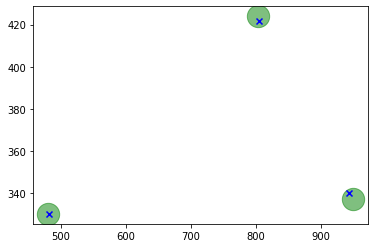

In [11]:
# Сложная версия с перебором зума и методов
def p3p_posit_iterated(points_2d, points_3d):
    distCoeffs = np.zeros((4, 1), dtype=np.float32)
    zoom_list = [
        np.float32(x)
        for x in [
            1920,
            1920 / 2,
            1920 / 4,
            1920 / 8,
            1920 * 2,
            1920 * 4,
            1920 * 8,
            1920 * 16,
            1920 * 32,
            1920 * 64,
            1920 * 128,
            1920 * 256,
        ]
    ]
    for flag in [cv2.SOLVEPNP_P3P, cv2.SOLVEPNP_AP3P]:
        for zoom in zoom_list:
            # for zoom in range(100,10000,100):
            cameraMatrix = np.array(
                [
                    [zoom, 0.00e00, 6.40e02],
                    [0.00e00, zoom, 3.60e02],
                    [0.00e00, 0.00e00, 1.00e00],
                ]
            )
            rez_list = cv2.solveP3P(
                points_3d, points_2d, cameraMatrix, distCoeffs, flag
            )
            print(zoom, flag, rez_list)
            if rez_list[0] != 0:
                rotation_vector, trans = rez_list[1][0], rez_list[2][0]
                rot, _ = cv2.Rodrigues(rotation_vector)
                print(zoom, flag)
                return rot, trans, zoom

    raise ValueError("rot/trans matrix empty")


rot, trans, zoom = p3p_posit_iterated(points_2d, points_3d)
intrin = np.array(
    [
        [zoom, 0.00e00, 6.40e02],
        [0.00e00, zoom, 3.60e02],
        [0.00e00, 0.00e00, 1.00e00],
    ]
)
check_rotation_matrix(points_2d, points_3d, intrin, rot, trans)


# solvePnP

In [44]:
def pnp_posit(points_2d, points_3d):
    distCoeffs = np.zeros((4, 1), dtype=np.float32)
    zoom_list = [
        np.float32(x)
        for x in [1920, 1920 / 2, 1920 / 4, 1920 / 8, 1920 * 2, 1920 * 4, 1920 * 8]
    ]
    flags = [
        cv2.SOLVEPNP_ITERATIVE,  # 0
        cv2.SOLVEPNP_P3P,  # 2
        cv2.SOLVEPNP_AP3P,  # 5
        cv2.SOLVEPNP_EPNP,  # 1
        cv2.SOLVEPNP_DLS,  # 3
        cv2.SOLVEPNP_UPNP,  # 4
        cv2.SOLVEPNP_IPPE,  # 6
        cv2.SOLVEPNP_IPPE_SQUARE,  # 7
        cv2.SOLVEPNP_SQPNP,  # 8
    ]
    for flag in flags:
        for zoom in zoom_list:
            cameraMatrix = np.array(
                [
                    [zoom, 0.00e00, 6.40e02],
                    [0.00e00, zoom, 3.60e02],
                    [0.00e00, 0.00e00, 1.00e00],
                ]
            )
            try:
                rez_list = cv2.solvePnP(
                    points_3d, points_2d, cameraMatrix, distCoeffs, flag
                )
                print(zoom, flag, rez_list)
                if rez_list[0] != 0:
                    rotation_vector, trans = rez_list[1][0], rez_list[2][0]
                    rot, _ = cv2.Rodrigues(rotation_vector)
                    print(zoom, flag)
                    return rot, trans
            except:
                print(flag, zoom, "doesnt work :(")

    raise ValueError("rot/trans matrix empty")


rot, trans = pnp_posit(points_2d, points_3d)
check_rotation_matrix(points_2d, points_3d, intrin, rot, trans)


0 1920.0 doesnt work :(
0 960.0 doesnt work :(
0 480.0 doesnt work :(
0 240.0 doesnt work :(
0 3840.0 doesnt work :(
0 7680.0 doesnt work :(
0 15360.0 doesnt work :(
2 1920.0 doesnt work :(
2 960.0 doesnt work :(
2 480.0 doesnt work :(
2 240.0 doesnt work :(
2 3840.0 doesnt work :(
2 7680.0 doesnt work :(
2 15360.0 doesnt work :(
5 1920.0 doesnt work :(
5 960.0 doesnt work :(
5 480.0 doesnt work :(
5 240.0 doesnt work :(
5 3840.0 doesnt work :(
5 7680.0 doesnt work :(
5 15360.0 doesnt work :(
1 1920.0 doesnt work :(
1 960.0 doesnt work :(
1 480.0 doesnt work :(
1 240.0 doesnt work :(
1 3840.0 doesnt work :(
1 7680.0 doesnt work :(
1 15360.0 doesnt work :(
3 1920.0 doesnt work :(
3 960.0 doesnt work :(
3 480.0 doesnt work :(
3 240.0 doesnt work :(
3 3840.0 doesnt work :(
3 7680.0 doesnt work :(
3 15360.0 doesnt work :(
4 1920.0 doesnt work :(
4 960.0 doesnt work :(
4 480.0 doesnt work :(
4 240.0 doesnt work :(
4 3840.0 doesnt work :(
4 7680.0 doesnt work :(
4 15360.0 doesnt work :(
6 19

ValueError: rot/trans matrix empty

# Кластер

In [216]:
from sklearn.cluster import KMeans

points_2d = np.array(
    [
        [180.0, 453.0],
        [980.0, 326.0],
        [505.0, 354.0],
        [649.0, 238.0],
        [692.0, 351.0],
        [547.0, 411.0],
    ]
)
kmeans = KMeans(n_clusters=2, random_state=0).fit(points_2d)
kmeans.labels_


array([1, 0, 0, 0, 0, 0], dtype=int32)

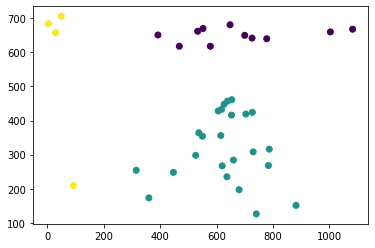

In [225]:
import pandas as pd

ENTRY = "input"  # local run
BASE_DIR = f"{ENTRY}/nfl-health-and-safety-helmet-assignment"
helmets = pd.read_csv(f"{BASE_DIR}/train_baseline_helmets.csv")
helm = helmets.loc[helmets["video_frame"] == "58102_002798_Sideline_302"].sort_values(
    ["left", "top"]
)
kmeans = KMeans(n_clusters=3, random_state=0).fit(helm[["left", "top"]].values)
plt.scatter(
    helm[["left", "top"]].values[:, 0],
    helm[["left", "top"]].values[:, 1],
    c=kmeans.labels_,
)


In [229]:
print(kmeans.labels_)
kmeans.cluster_centers_


[2 2 2 2 1 1 0 1 0 1 0 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 0 1 1 1
 0 0]


array([[678.36363636, 650.90909091],
       [629.125     , 320.20833333],
       [ 43.25      , 564.25      ]])